
# Assignment 2: Information Extraction
## Learning goals of this assignment:
1. Become familiar with the intricacies and challenges of time expression labelling and finding matching events
2. Define a set of patterns for extracting time patterns from text
3. Calculate precision for the output of your code on an unseen text
4. Gain insight into the importance of pattern generalizability 

Note that the assignment will be graded with a Pass/Fail system.

Whenever you have any questions, simply talk to the TAs or send a mail to Manuela (manuela.bergau@ru.nl), Nienke (nienke.wessel@ru.nl), or Justine (j.winkler@student.ru.nl). We would appreciate it if you do not contact us via WhatsApp for non-urgent matters, so we can keep our TA work and private life (somewhat) separate.

_We only support the use of [Google Colab](https://https://colab.research.google.com/) as all assignments have been implemented and tested using this. In case of (strange) bugs on other platforms, please consider switching to Colab to make sure that we can provide with all the help you may need._

## Installation
First, make sure pandas, plotly and nltk are installed:

In [43]:
!pip install numpy
!pip install pandas

## Extracting timelines and matching events from biographies
### Uploading files to Colab

Similar to the previous assignment you need to upload some files that are needed for the assignemnt in the working directory. For this assignment you need to upload the files *KatherineJohnson.txt*, *MaryJackson.txt* and *utils.py*.

Instead of using the upload functionality, you can also download the file directly in the notebook. Run the following command in a code cell to do so:

```
!wget http://transfer.sh/nxhiju/MaryJackson.txt
!wget http://transfer.sh/SAJ6Sg/KatherineJohnson.txt
!wget http://transfer.sh/BiOSQt/utils.py
```

### Loading & inspecting the KatherineJohnson.txt

The task of information extraction often focuses on extracting events from text. We want to know who did what when and why. In this exercise we focus on the ‘when’ aspect and you will create timelines of events described in two texts (the biographies of Katherine Johnson and Mary Jackson) and you will find the matching events (i.e. overlapping dates) of the two timelines.

Here, your goal is to identify and extract date expressions. 
A **date expression** is a sequence within the text (can contain letters, numbers, and/or punctuation) that expresses a point in time or a period of time. First, you want to get an impression of the date expressions in the biography of Katherine Johnson. 

Run the next cell to see KatherineJohnson.txt. *Do not yet look at MaryJackson.txt, an extraction of the biography of Mary Jackson!*

In [44]:
# Make sure KatherineJohnson.txt and MaryJackson.txt are in the working directory. 
import os

def read_file(file_name):
  with open(file_name, "r") as f:
    return f.read()

working_dir = os.getcwd()  # get our working directory
text_katherine = read_file(os.path.join(working_dir, 'KatherineJohnson.txt'))
print(text_katherine)

Katherine Johnson
From Wikipedia, the free encyclopedia

Creola Katherine Johnson (née Coleman; August 26, 1918 – February 24, 2020) was an American mathematician whose calculations of orbital mechanics as a NASA employee were critical to the success of the first and subsequent U.S. crewed spaceflights.[1] During her 33-year career at NASA and its predecessor, she earned a reputation for mastering complex manual calculations and helped pioneer the use of computers to perform the tasks.

Early life
Katherine Johnson was born as Creola Katherine Coleman on August 26, 1918, in White Sulphur Springs, West Virginia, to Joylette Roberta (née Lowe) and Joshua McKinley Coleman.[5][6][7][8] She was the youngest of four children.[9] Her mother was a teacher and her father was a lumberman, farmer, and handyman, and worked at the Greenbrier Hotel.[6][10]

External video
video icon Interview with West Virginia State University President Anthony Jenkins on Johnson's studies and career, October 21, 2

#### Task 1: Examine the biography of Katherine Johnson, and notice the patterns in which the date expressions occur. List and describe your observations in the next cell. 

Exact years are easy in patterns, as these occur in the form: "in <4 numbers representing the year>", which in regex would be "[Ii]n \d{4}". Because of the timeframe of this particular text, this could be specified to "[Ii]n 19\d{2}" as all the exact years occur in the 20th century. It should be noted that sometimes "in" is replaced by "the" or something similar ("a").

Periods specified with exact years are also easy to recognize: "from \<year> to \<year>". One exception to this is "From 1958 until her retirement in 1986", for which we need to leave a lot of freedom for 'filler' words. However, the second year would be picked up with the first paragraph, so linking these using a regular "from \<year>" may be the easiest strategy.

Exact dates follow a similar pattern: "\<Month> \<day>, \<year>", which are a bit harder to express using regular expressions but can be done by listing the individual months. The day is slightly different from the year as it can be either 1 or 2 digits, but again this can be done using regular expressions. Directly before these types of pattners is usually a 'on', but not always.

#### Task 2: Implement the function *sentence_tokenize_text* so that it splits a text into a list of sentences. 

In [45]:
import re

def sentence_tokenize_text(text):
  """
  :param text: An input text, i.e. a string
  :return: A list of strings, where each string is one sentence
  """
  # Regex explanation: sentences start with a capital [A-Z], are followed by 
  # some characters .*?, end with a period, exclamation mark, question mark, or
  # whitespace [.!\?\\n]. The final clause [^a-zA-Z]* is there mainly for the 
  # references, but the idea is that the sentence continues until any capitals 
  # are encountered. This filters out most sentences, but there are still broken
  # sentences (e.g. names), which are too hard to differentiate.
  return re.findall('[A-Z].*?[.!\?][^a-zA-Z]*', text.strip())
  
#sentence_tokenize_text(text_katherine)  # You can display the result for testing. 

#### Task 3: Implement the function *extract_date_expressions* so that it extracts date expressions from sentences.
The function should take in our list of sentences and return a pandas DataFrame. This DataFrame has two columns:
- Date: The extracted date expressions
- Sentence: The sentence from which a data expression was extracted 

**Write your own patterns** and do not rely on libraries that automatically extract date expressions as learning about regular expressions is one of the learning objectives of the exercise.

*Hint: Check out https://regexr.com/ for testing and refining the regular expressions you use to capture date expressions. It also has a handy cheat sheet you can use. *

*For coding newbies: You can contact the TAs to get a regex example function in Python.*

In [46]:
import pandas as pd

def extract_date_expressions(sentences):
  """
  :param sentences: A list of strings, where each string is one sentences
  :return: A pandas DataFrame with the columns 
                "Date" (extracted date expressions as a string)
                "Sentence" (sentences from which a date expression was extracted)
  """
  # Regex explanation: This regex encompasses either the specific date or just 
  # the year by one outer group that only differentiates at the end. The first 
  #part consists of Month followed by a number 1-31 (meaning February 31 is
  # possible, but this is ignored), followed by possibly a comma and the year in
  # 4 digits. The second possibility is just 4 digits for the year, and there's 
  # probably a better way to do that but this works so i'm keeping it :)
  regex = '(?:(?:January?|February?|March?|April?|May?|June?|July?|August?|September?|October?|November?|December?) (?:[1-9]?|[1-2][0-9]?|30?|31?),? \d{4})'
  
  new_sentences = []
  dates = []

  for sentence in sentences:
    matches = re.findall(regex, sentence)
    # Skip sentences without a date
    if matches:
      
      # If multiple matches, make multiple rows
      for match in matches:
        new_sentences.append(sentence)
        dates.append(match)

  return pd.DataFrame({'Date': dates,
                       'Sentence': new_sentences})

# Apply the function to the tokenized text:
df_dates_katherine = extract_date_expressions(sentence_tokenize_text(text_katherine)) 
pd.set_option('display.max_rows', df_dates_katherine.shape[0]+1)
#print(df_dates_katherine) # use this for testing

#### Task 4: Implement the function *dates_to_iso8601* so that it converts a date expression string to the ISO 8601 date standard.
Then, add the ISO 8601 converted dates as a column ("ISO") to our dataframe. 

You can find more info and examples on https://www.iso.org/iso-8601-date-and-time-format.html. 

*Hint: For converting strings into ISO-compliant dates, check out Python’s inbuilt datetime module. With a quick Google search, you’ll find functions in there that can make this task a lot easier.*

In [59]:
from datetime import datetime

def date_expression_to_iso8601(date_string):
  """
  :param date_string: A string containing a date expression
  :return: A string containing the date in ISO 8601 format
  """
  
  # When multiple dates are mentioned in a sentence, separate them
  if isinstance(date_string, list):
    return [date_expression_to_iso8601(date) for date in date_string]
  
  # If no date is given, assume it's January 1st
  if len(date_string) == 4:
    date_string = 'January 1, ' + date_string
  
  # Strip time into ISO-8601 format
  return datetime.strptime(date_string, '%B %d, %Y')

# Now, add a column "ISO" to your DataFrame
isos = []
for date in df_dates_katherine['Date']:
  isos.append(date_expression_to_iso8601(date))
df_dates_katherine['ISO'] = isos
#df_dates_katherine  # use this for testing

#### Task 5: Combine the previous steps in the function *get_sorted_df_from_file_name* so that it runs the whole date extraction pipeline and returns a DataFrame.
**Make sure to order the DataFrame rows chronologically according to the ISO dates!** 

Consider the following example text: 

> This is an example text about interesting upcoming dates. Halloween takes place on 31 October 2021. Our Christmas holiday is from Friday 24 December 2021 - Friday 7 January 2022. We will celebrate Sinterklaas on 5 December 2021.

Here's an illustration of what the example text's DataFrame should look like: 

|ISO |Date | Sentence |
|----:|----:|:----|
|2021-10-31 |31 October 2021| Halloween takes place on 31 October 2021.|
|2021-12-05 |5 December 2021| We will celebrate Sinterklaas on 5 December 2021.|
|2021-12-24 |24 December 2021| Our Christmas holiday is from Friday 24 December 2021 - Friday 7 January 2022.|
|2022-01-07 |7 January 2022| Our Christmas holiday is from Friday 24 December 2021 - Friday 7 January 2022.|

In [60]:
def get_sorted_df_from_file_name(file_name):
  """
  :param file_name: A string containing the full path to a file
  :return: A pandas DataFrame with the columns "Date", "Sentence" and "ISO" 
          (see above), where rows are sorted according to "ISO"
  """
  text = read_file(file_name)
  df = extract_date_expressions(sentence_tokenize_text(text))
  
  isos = []
  for date in df['Date']:
    isos.append(date_expression_to_iso8601(date))
  df['ISO'] = isos
  df = df.set_index('ISO')
  return df.sort_values('ISO')

get_sorted_df_from_file_name(os.path.join(working_dir, 'KatherineJohnson.txt'))

,Date,Sentence
ISO,,
1918-08-26,"August 26, 1918",Creola Katherine Johnson (née Coleman; August ...
1918-08-26,"August 26, 1918",Katherine Johnson was born as Creola Katherine...
1961-05-05,"May 5, 1961","She calculated the trajectory for the May 5, 1..."
1961-05-05,"May 5, 1961","On May 5, 1961, her work helped to ensure that..."
2020-02-24,"February 24, 2020",Creola Katherine Johnson (née Coleman; August ...


### Manual labeling: KatherineJohnson.txt
To evaluate your date expression pipeline, you first need to have gold labels. In this assignment, we use a specified labeling format. This also makes it easier for the Teaching Team to follow your calculations below. Let's familiarize ourselves with this format. 

Look at our example text again:

> This is an example text about interesting upcoming dates. Halloween takes place on 31 October 2021. Our Christmas holiday is from Friday 24 December 2021 - Friday 7 January 2022. We will celebrate Sinterklaas on 5 December 2021.


This is how we store the gold labels for this example text:
~~~python
example_manual_labels = [
  {"Sentence": "This is an example text about interesting upcoming dates.", 
      "Dates": []},
  {"Sentence": "The next Halloween takes place on 31 October 2021.", 
      "Dates": ["2021-10-31"]},
  {"Sentence": "Our Christmas holiday is from Friday 24 December 2021-Friday 7 January 2022.", 
      "Dates": ["2021-12-24", "2022-01-07"]},
  {"Sentence": "We will celebrate Sinterklaas on 5 December 2021.", 
      "Dates": ["2021-12-05"]}
  ]
~~~

As you can see, we use a list of dictionaries. We have one dictionary for each sentence. This dictionary has two keys:
- Key "Sentence": The corresponding value is the sentence (i.e. a string).
- Key "Dates": The corresponding value is a list of all date expressions (strings; correctly converted to the ISO 8601 date standard) that appear in that sentence. If a sentence does not contain any date expressions, this list is empty. 

#### Task 6: Manually label all sentences from KatherineJohnson.txt.   
Go through the text in KatherineJohnson.txt and fill the list *katherine_manual_labels* following the format described above. 

In [61]:
katherine_manual_labels = [
  {"Sentence": "Katherine Johnson",
   "Dates": []},
  {"Sentence": "From Wikipedia, the free encyclopedia",
   "Dates": []},
  {"Sentence": "Early life",
   "Dates": []},
  {"Sentence": "Katherine Johnson was born as Creola Katherine Coleman on August 26, 1918, in White Sulphur Springs, West Virginia, to Joylette Roberta (née Lowe) and Joshua McKinley Coleman.[5][6][7][8]",
   "Dates": ["1918-08-26"]},
  {"Sentence": "She was the youngest of four children.[9]",
   "Dates": []},
  {"Sentence": "Her mother was a teacher and her father was a lumberman, farmer, and handyman, and worked at the Greenbrier Hotel.[6][10]",
   "Dates": []},
  {"Sentence": "Johnson showed strong mathematical abilities from an early age.",
   "Dates": []},
  {"Sentence": "Because Greenbrier County did not offer public schooling for African-American students past the eighth grade, the Colemans arranged for their children to attend high school in Institute, West Virginia. ",
   "Dates": []},
  {"Sentence": "This school was on the campus of West Virginia State College (WVSC).[11] Johnson was enrolled when she was ten years old.[12]",
   "Dates": []},
  {"Sentence": "The family split their time between Institute during the school year and White Sulphur Springs in the summer.[13]",
   "Dates": []},
  {"Sentence": "External video",
   "Dates": []},
  {"Sentence": "video icon Interview with West Virginia State University President Anthony Jenkins on Johnson's studies and career, October 21, 2019, C-SPAN",
   "Dates": ["2019-10-21"]},
  {"Sentence": "After graduating from high school at 14, Johnson enrolled at West Virginia State, a historically black college.[14]",
   "Dates": []},
  {"Sentence": " As a student, she took every math course offered by the college.",
   "Dates": []},
  {"Sentence": " Multiple professors mentored her, including the chemist and mathematician Angie Turner King, who had mentored Coleman throughout high school, and W. W. Schieffelin Claytor, the third African-American to receive a Ph.D. in mathematics. ",
   "Dates": []},
  {"Sentence": "Claytor added new mathematics courses just for Johnson.[15]",
   "Dates": []},
  {"Sentence": " She graduated summa cum laude in 1937, with degrees in mathematics and French, at age 18.[16][12][17] ",
   "Dates": []},
  {"Sentence": "Johnson was a member of Alpha Kappa Alpha.[18] ",
   "Dates": []},
  {"Sentence": "She took on a teaching job at a black public school in Marion, Virginia.[14][19]",
   "Dates": []},
  {"Sentence": "In 1939, after marrying her first husband, James Goble, she left her teaching job and enrolled in a graduate math program. ",
   "Dates": []},
  {"Sentence": "She quit one year later after becoming pregnant and chose to focus on her family life.[14]",
   "Dates": []},
  {"Sentence": " She was the first African-American woman to attend graduate school at West Virginia University in Morgantown, West Virginia.",
   "Dates": []},
  {"Sentence": " Through WVSC's president, Dr. John W. Davis, she became one of three African-American students,[14] and the only woman, selected to integrate the graduate school after the 1938 United States Supreme Court ruling Missouri ex rel. Gaines v. Canada. ",
   "Dates": []},
  {"Sentence": "The court ruled that states that provided public higher education to white students also had to provide it to black students, to be satisfied either by establishing black colleges and universities or by admitting black students to previously white-only universities.[10][20]",
   "Dates": []},
  {"Sentence": "Career",
   "Dates": []},
  {"Sentence": "Photograph of Johnson sitting at a desk",
   "Dates": []},
  {"Sentence": "Johnson working as a \"computer\" at NASA in 1966",
   "Dates": []},
  {"Sentence": "Johnson decided on a career as a research mathematician, although this was a difficult field for African Americans and women to enter. ",
   "Dates": []},
  {"Sentence": "The first jobs she found were in teaching.",
   "Dates": []},
  {"Sentence": " At a family gathering in 1952, a relative mentioned that the National Advisory Committee for Aeronautics (NACA) was hiring mathematicians.[14]",
   "Dates": []},
  {"Sentence": " At the Langley Memorial Aeronautical Laboratory, based in Hampton, Virginia, near Langley Field, NACA hired African-American mathematicians as well as whites for their Guidance and Navigation Department. ",
   "Dates": []},
  {"Sentence": "Johnson accepted a job offer from the agency in June 1953.[6]",
   "Dates": []},
  {"Sentence": "According to an oral history archived by the National Visionary Leadership Project:",
   "Dates": []},
  {"Sentence": "At first she [Johnson] worked in a pool of women performing math calculations.",
   "Dates": []},
  {"Sentence": " Katherine has referred to the women in the pool as virtual \"computers who wore skirts\".",
   "Dates": []},
  {"Sentence": " Their main job was to read the data from the black boxes of planes and carry out other precise mathematical tasks. ",
   "Dates": []},
  {"Sentence": "Then one day, Katherine (and a colleague) were temporarily assigned to help the all-male flight research team. ",
   "Dates": []},
  {"Sentence": "Katherine's knowledge of analytic geometry helped make quick allies of male bosses and colleagues to the extent that, \"they forgot to return me to the pool\".",
   "Dates": []},
  {"Sentence": " While the racial and gender barriers were always there, Katherine says she ignored them.",
   "Dates": []},
  {"Sentence": " Katherine was assertive, asking to be included in editorial meetings (where no women had gone before).",
   "Dates": []},
  {"Sentence": " She simply told people she had done the work and that she belonged.[6]",
   "Dates": []},
  {"Sentence": "From 1953 to 1958, Johnson worked as a computer,[21] analyzing topics such as gust alleviation for aircraft.",
   "Dates": []},
  {"Sentence": " Originally assigned to the West Area Computers section supervised by mathematician Dorothy Vaughan, Johnson was reassigned to the Guidance and Control Division of Langley's Flight Research Division. ",
   "Dates": []},
  {"Sentence": "It was staffed by white male engineers.[22]",
   "Dates": []},
  {"Sentence": " In keeping with state racial segregation laws, and federal workplace segregation introduced under President Woodrow Wilson in the early 20th century, Johnson and the other African-American women in the computing pool were required to work, eat, and use restrooms that were separate from those of their white peers.",
   "Dates": []},
  {"Sentence": "Their office was labeled as \"Colored Computers\". In an interview with WHRO-TV, Johnson stated that she \"didn't feel the segregation at NASA, because everybody there was doing research.",
   "Dates": []},
  {"Sentence": " You had a mission and you worked on it, and it was important to you to do your job ... and play bridge at lunch.\" She added: \"I didn't feel any segregation.",
   "Dates": []},
  {"Sentence": " I knew it was there, but I didn't feel it.\"[23]",
   "Dates": []},
  {"Sentence": "NACA disbanded the colored computing pool in 1958 when the agency was superseded by NASA, which adopted digital computers.",
   "Dates": []},
  {"Sentence": " Although the installation was desegregated,[22] forms of discrimination were still pervasive.",
   "Dates": []},
  {"Sentence": " Johnson recalled that era:",
   "Dates": []},
  {"Sentence": "We needed to be assertive as women in those days – assertive and aggressive – and the degree to which we had to be that way depended on where you were.",
   "Dates": []},
  {"Sentence": " I had to be.",
   "Dates": []},
  {"Sentence": " In the early days of NASA women were not allowed to put their names on the reports – no woman in my division had had her name on a report.",
   "Dates": []},
  {"Sentence": " I was working with Ted Skopinski and he wanted to leave and go to Houston ... but Henry Pearson, our supervisor – he was not a fan of women – kept pushing him to finish the report we were working on.",
   "Dates": []},
  {"Sentence": "Finally, Ted told him, \"Katherine should finish the report, she's done most of the work anyway.\"",
   "Dates": []},
  {"Sentence": " So Ted left Pearson with no choice; I finished the report and my name went on it, and that was the first time a woman in our division had her name on something.[24]",
   "Dates": []},
  {"Sentence": "From 1958 until her retirement in 1986, Johnson worked as an aerospace technologist, moving during her career to the Spacecraft Controls Branch.",
   "Dates": []},
  {"Sentence": " She calculated the trajectory for the May 5, 1961 space flight of Alan Shepard, the first American in space.[1]",
   "Dates": ["1961-05-05"]},
  {"Sentence": " She also calculated the launch window for his 1961 Mercury mission.[25]",
   "Dates": []},
  {"Sentence": " She plotted backup navigation charts for astronauts in case of electronic failures.[6]",
   "Dates": []},
  {"Sentence": " When NASA used electronic computers for the first time to calculate John Glenn's orbit around Earth, officials called on Johnson to verify the computer's numbers; Glenn had asked for her specifically and had refused to fly unless Johnson verified the calculations.[1][26][27]",
   "Dates": []},
  {"Sentence": "Biography.com states these were \"far more difficult calculations, to account for the gravitational pulls of celestial bodies\".[28]",
   "Dates": []},
  {"Sentence": " Author Margot Lee Shetterly stated, \"So the astronaut who became a hero, looked to this black woman in the still-segregated South at the time as one of the key parts of making sure his mission would be a success.\" ",
   "Dates": []},
  {"Sentence": " She added that, in a time where computing was \"women's work\" and engineering was left to men, \"it really does have to do with us over the course of time sort of not valuing that work that was done by women, however necessary, as much as we might. ",
   "Dates": []},
  {"Sentence": "And it has taken history to get a perspective on that.\"[29]",
   "Dates": []},
  {"Sentence": "Johnson later worked directly with digital computers. ",
   "Dates": []},
  {"Sentence": "Her ability and reputation for accuracy helped to establish confidence in the new technology.[28]",
   "Dates": []},
  {"Sentence": " In 1961, her work helped to ensure that Alan Shepard's Freedom 7 Mercury capsule would be found quickly after landing, using the accurate trajectory that had been established.[30]",
   "Dates": []},
  {"Sentence": "She also helped to calculate the trajectory for the 1969 Apollo 11 flight to the Moon.[1][28]",
   "Dates": []},
  {"Sentence": " During the Moon landing, Johnson was at a meeting in the Pocono Mountains.",
   "Dates": []},
  {"Sentence": " She and a few others crowded around a small television screen watching the first steps on the Moon.[1]",
   "Dates": []},
  {"Sentence": " In 1970, Johnson worked on the Apollo 13 Moon mission.",
   "Dates": []},
  {"Sentence": "When the mission was aborted, her work on backup procedures and charts helped set a safe path for the crew's return to Earth,[28] creating a one-star observation system that would allow astronauts to determine their location with accuracy. ",
   "Dates": []},
  {"Sentence": " In a 2010 interview, Johnson recalled, \"Everybody was concerned about them getting there.",
   "Dates": []},
  {"Sentence": " We were concerned about them getting back.\"[30]",
   "Dates": []},
  {"Sentence": " Later in her career, Johnson worked on the Space Shuttle program, the Earth Resources Satellite,[1][28] and on plans for a mission to Mars.[31]",
   "Dates": []},
  {"Sentence": "Johnson spent her later years encouraging students to enter the fields of science, technology, engineering, and mathematics (STEM).[32]",
   "Dates": []},
  {"Sentence": "Text from https://en.wikipedia.org/wiki/Katherine_Johnson, adapted by the teaching team",
   "Dates": []}  
]

Now that we have labels for KatherineJohnson.txt, we can plot a confusion matrix to get an impression of your extraction procedure's performance:

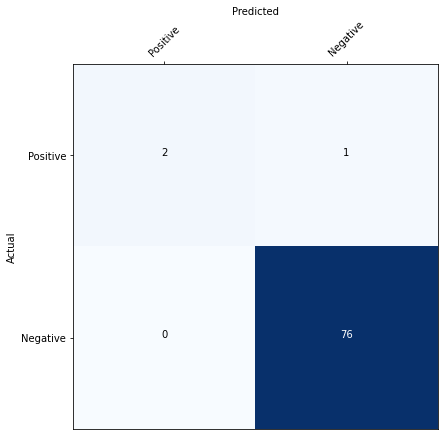

In [62]:
from utils import plot_confusion_matrix

plot_confusion_matrix(manual_labels = katherine_manual_labels, 
                      sorted_date_df =get_sorted_df_from_file_name(os.path.join(working_dir, 'KatherineJohnson.txt')),
                      normalize    = False,
                      title_names = ['Positive','Negative'])

#### Task 7: Manually calculate the precision of your date expression procedure on KatherineJohnson.txt.
Write your calculation into the cell below. 

Hint: You can use $\LaTeX$ here. 
- To display a formula inline, surround it by the '\$' sign. 
    - For example, '\$ 4=2^2 \$' will be displayed like this: $4=2^2$
- To display a formula in a block, surround it by '\$\$'. 
    - For example, '\$\$ 16=4^2 \$\$' will be displayed like this: $$16=4^2$$

For the precision we divide the number of true positives by the total number of 
positive predictions (TP + FP)
$\frac{2}{2 + 1} = \frac{2}{3}$

**Now, repeat the following steps until you are satisfied with the performance:** 
1. Run the date expression procedure on KatherineJohnson.txt. 
2. Make adaptations to your code if necessary. 
3. Go through the output manually and calculate precision. **Make sure the cell above contains the latest calculation.** 

Once you are satisfied with your performance, proceed to the next part of this assignment. 

### Applying the extraction procedure to the unseen MaryJackson.txt
Next, we will test your date extraction procedure and see how it performs on the unseen file MaryJackson.txt. First, let's have a look at the text inside this file: 

In [63]:
text_mary = read_file(os.path.join(working_dir, 'MaryJackson.txt'))
print(text_mary)

Mary Jackson (engineer)
From Wikipedia, the free encyclopedia

Mary Jackson (née Winston;[1] April 9, 1921 – February 11, 2005) was an American mathematician and aerospace engineer at the National Advisory Committee for Aeronautics (NACA), which in 1958 was succeeded by the National Aeronautics and Space Administration (NASA). She worked at Langley Research Center in Hampton, Virginia, for most of her career. She started as a computer at the segregated West Area Computing division in 1951. She took advanced engineering classes and, in 1958, became NASA's first black female engineer.

After 34 years at NASA, Jackson had earned the most senior engineering title available. She realized she could not earn further promotions without becoming a supervisor. She accepted a demotion to become a manager of both the Federal Women's Program, in the NASA Office of Equal Opportunity Programs and of the Affirmative Action Program. In this role, she worked to influence the hiring and promotion of wome

#### Task 8: Manually label all sentences from mary.txt
Now go through the text in mary.txt and fill the list *mary_manual_labels* just like you previously did for KatherineJohnson.txt: 

In [64]:
{"Sentence": "Finally, Ted told him, \"Katherine should finish the report, she's done most of the work anyway.\"",
   "Dates": []},# Generate sentences automatically:
string = "mary_manual_labels = [\n"  
sentences = sentence_tokenize_text(text_mary)
for sentence in sentences:
  string += '<\"Sentence\": \"{}\",\n  \"Dates\": []>,\n  '.format(sentence.strip())
print(string)
  

mary_manual_labels = [
<"Sentence": "Mary Jackson (née Winston;[1] April 9, 1921 – February 11, 2005) was an American mathematician and aerospace engineer at the National Advisory Committee for Aeronautics (NACA), which in 1958 was succeeded by the National Aeronautics and Space Administration (NASA).",
  "Dates": []>,
  <"Sentence": "She worked at Langley Research Center in Hampton, Virginia, for most of her career.",
  "Dates": []>,
  <"Sentence": "She started as a computer at the segregated West Area Computing division in 1951.",
  "Dates": []>,
  <"Sentence": "She took advanced engineering classes and, in 1958, became NASA's first black female engineer.",
  "Dates": []>,
  <"Sentence": "After 34 years at NASA, Jackson had earned the most senior engineering title available.",
  "Dates": []>,
  <"Sentence": "She realized she could not earn further promotions without becoming a supervisor.",
  "Dates": []>,
  <"Sentence": "She accepted a demotion to become a manager of both the Federa

In [65]:
mary_manual_labels = [
{"Sentence": "Mary Jackson (engineer)",
  "Dates": []},
  {"Sentence": "From Wikipedia, the free encyclopedia",
  "Dates": []},
  {"Sentence": "Mary Jackson (née Winston;[1] April 9, 1921 – February 11, 2005) was an American mathematician and aerospace engineer at the National Advisory Committee for Aeronautics (NACA), which in 1958 was succeeded by the National Aeronautics and Space Administration (NASA). ",
  "Dates": ["1921-04-09", "2005-02-11"]},
  {"Sentence": "She worked at Langley Research Center in Hampton, Virginia, for most of her career. ",
  "Dates": []},
  {"Sentence": "She started as a computer at the segregated West Area Computing division in 1951. ",
  "Dates": []},
  {"Sentence": "She took advanced engineering classes and, in 1958, became NASA's first black female engineer.",
  "Dates": []},
  {"Sentence": "After 34 years at NASA, Jackson had earned the most senior engineering title available. ",
  "Dates": []},
  {"Sentence": "She realized she could not earn further promotions without becoming a supervisor. ",
  "Dates": []},
  {"Sentence": "She accepted a demotion to become a manager of both the Federal Women's Program, in the NASA Office of Equal Opportunity Programs and of the Affirmative Action Program. ",
  "Dates": []},
  {"Sentence": "In this role, she worked to influence the hiring and promotion of women in NASA's science, engineering, and mathematics careers.",
  "Dates": []},
  {"Sentence": "Jackson's story features in the 2016 non-fiction book Hidden Figures: The American Dream and the Untold Story of the Black Women Who Helped Win the Space Race. ",
  "Dates": []},
  {"Sentence": "She is one of the three protagonists in Hidden Figures, the film adaptation released the same year.",
  "Dates": []},
  {"Sentence": "In 2019, Jackson was posthumously awarded the Congressional Gold Medal.[2] ",
  "Dates": []},
  {"Sentence": "In 2021, the Washington, D.",
  "Dates": []},
  {"Sentence": "C. ",
  "Dates": []},
  {"Sentence": "NASA was renamed the Mary W. ",
  "Dates": []},
  {"Sentence": "Jackson NASA Headquarters. ",
  "Dates": []},
  {"Sentence": "NASA held a virtual ceremony for the naming.[3]",
  "Dates": []},
  {"Sentence": "Personal life",
  "Dates": []},
  {"Sentence": "Mary Winston was born on April 9, 1921, to Ella Winston (née Scott) and Frank Winston.[4] ",
  "Dates": ["1921-04-09"]},
  {"Sentence": "She grew up in Hampton, Virginia, where she graduated from the all-black George P. ",
  "Dates": []},
  {"Sentence": "Phenix Training School with highest honors.[5]",
  "Dates": []},
  {"Sentence": "Mary Jackson earned bachelor's degrees in mathematics and physical science from Hampton University in 1942.[6][7] ",
  "Dates": []},
  {"Sentence": "She was a member of the Alpha Kappa Alpha.[6]",
  "Dates": []},
  {"Sentence": "Jackson served for more than 30 years as a Girl Scout leader.[5] ",
  "Dates": []},
  {"Sentence": "She was noted in the 1970s for helping African American children in her community create a miniature wind tunnel for testing airplanes.[7][8][5]",
  "Dates": []},
  {"Sentence": "Jackson was married on November 18, 1944 to Levi Jackson, Sr., ",
  "Dates": ["1944-11-18"]},
  {"Sentence": "U.",
  "Dates": []},
  {"Sentence": "S. ",
  "Dates": []},
  {"Sentence": "Navy,[7][9] and had two children, Levi Jackson, Jr. ",
  "Dates": []},
  {"Sentence": "Carolyn Marie Lewis.[7] ",
  "Dates": []},
  {"Sentence": "She died on February 11, 2005, age 83.[6]",
  "Dates": ["2005-2-11"]},
  {"Sentence": "Career",
  "Dates": []},
  {"Sentence": "Jackson (first row, far right) with the 4'x4' Supersonic Pressure Tunnel staff in 1956[10]",
  "Dates": []},
  {"Sentence": "Black and white photograph of Mary Jackson holding a model in a wind tunnel",
  "Dates": []},
  {"Sentence": "Jackson holding a wind tunnel model in 1977",
  "Dates": []},
  {"Sentence": "Black and white photograph of Mary Jackson standing in front of large instruments, holding a clipboard and pencil",
  "Dates": []},
  {"Sentence": "Jackson working at the Langley Research Center in 1977",
  "Dates": []},
  {"Sentence": "Mary Jackson sitting, adjusting a control on an instrument",
  "Dates": []},
  {"Sentence": "Jackson working at a control panel in 1980",
  "Dates": []},
  {"Sentence": "After graduation, Mary Jackson taught mathematics for a year at an African-American school in Calvert County, Maryland.[5] ",
  "Dates": []},
  {"Sentence": "At that time, public schools were still segregated across the South. ",
  "Dates": []},
  {"Sentence": "She also began tutoring high school and college students, which she continued to do throughout her life.[11]",
  "Dates": []},
  {"Sentence": "By 1943, she had returned to Hampton, where she became a bookkeeper at the National Catholic Community Center there. ",
  "Dates": []},
  {"Sentence": "She worked as a receptionist and clerk at the Hampton Institute's Health Department. ",
  "Dates": []},
  {"Sentence": "She was pregnant during this time and eventually returned home for the birth of her son. ",
  "Dates": []},
  {"Sentence": "In 1951, she became a clerk at the Office of the Chief Army Field Forces at Fort Monroe.[5][11]",
  "Dates": []},
  {"Sentence": "In 1951, Jackson was recruited by the National Advisory Committee for Aeronautics (NACA), which in 1958 was succeeded by the National Aeronautics and Space Administration (NASA).[7][8][12] ",
  "Dates": []},
  {"Sentence": "She started as a research mathematician, or computer, at the Langley Research Center in her hometown of Hampton, Virginia. ",
  "Dates": []},
  {"Sentence": "She worked under Dorothy Vaughan in the segregated West Area Computing Section.[5]",
  "Dates": []},
  {"Sentence": "In 1953, she accepted an offer to work for engineer Kazimierz Czarnecki in the Supersonic Pressure Tunnel. ",
  "Dates": []},
  {"Sentence": "The 4 by 4 foot (1.2 ",
  "Dates": []},
  {"Sentence": "W) wind tunnel was used to study forces on a model by generating winds at almost twice the speed of sound.[5] ",
  "Dates": []},
  {"Sentence": "Czarnecki encouraged Jackson to undergo training so that she could be promoted to an engineer. ",
  "Dates": []},
  {"Sentence": "She needed to take graduate-level courses in mathematics and physics to qualify for the job. ",
  "Dates": []},
  {"Sentence": "They were offered in a night program by the University of Virginia, held at the all-white Hampton High School. ",
  "Dates": []},
  {"Sentence": "Jackson petitioned the City of Hampton to allow her to attend the classes. ",
  "Dates": []},
  {"Sentence": "After completing the courses, she was promoted to aerospace engineer in 1958, and became NASA's first black female engineer.[13][8][5] ",
  "Dates": []},
  {"Sentence": "In the early 60's she analyzed data from wind tunnel experiments and real-world aircraft flight experiments at the Theoretical Aerodynamics Branch of the Subsonic-Transonic Aerodynamics Division at Langley.[7] ",
  "Dates": []},
  {"Sentence": "Her goal was to understand air flow, including thrust and drag forces, in order to improve United States planes.[7]",
  "Dates": []},
  {"Sentence": "Jackson worked as an engineer in several NASA divisions: the Compressibility Research Division, Full-Scale Research Division, High-Speed Aerodynamics Division, and the Subsonic-Transonic Aerodynamics Division.[11] ",
  "Dates": []},
  {"Sentence": "She ultimately authored or co-authored 12 technical papers for NACA and NASA.[11][14][15][16] ",
  "Dates": []},
  {"Sentence": "She worked to help women and other minorities to advance their careers, including advising them how to study in order to qualify for promotions.[17]",
  "Dates": []},
  {"Sentence": "By 1979, Jackson had achieved the most senior title within the engineering department. ",
  "Dates": []},
  {"Sentence": "She decided to take a demotion in order to serve as an administrator in the Equal Opportunity Specialist field. ",
  "Dates": []},
  {"Sentence": "After undergoing training at NASA Headquarters, she returned to Langley. ",
  "Dates": []},
  {"Sentence": "She worked to make changes and highlight women and other minorities who were accomplished in the field. ",
  "Dates": []},
  {"Sentence": "She served as both the Federal Women's Program Manager in the Office of Equal Opportunity Programs and as the Affirmative Action Program Manager, and she worked to influence the career paths of women in science, engineering, and mathematics positions at NASA.[5][17] ",
  "Dates": []},
  {"Sentence": "She continued to work at NASA until her retirement in 1985.[6]",
  "Dates": []},
  {"Sentence": "Legacy",
  "Dates": []},
  {"Sentence": "The 2016 film Hidden Figures recounts the NASA careers of Jackson, Katherine Johnson, and Dorothy Vaughan, specifically their work on Project Mercury during the Space Race. ",
  "Dates": []},
  {"Sentence": "The film is based on the book of the same name by Margot Lee Shetterly. ",
  "Dates": []},
  {"Sentence": "Jackson is portrayed in the film by Janelle Monáe.[18]",
  "Dates": []},
  {"Sentence": "In 2018, the Salt Lake City School Board voted that Jackson Elementary School in Salt Lake City, Utah, would from then on be officially named after Mary Jackson rather than (as it used to be) after President Andrew Jackson.[19]",
  "Dates": []},
  {"Sentence": "NASA's headquarters building in Washington, D.",
  "Dates": []},
  {"Sentence": "C. ",
  "Dates": []},
  {"Sentence": "Mary W. ",
  "Dates": []},
  {"Sentence": "Jackson NASA Headquarters on February 26, 2021.[20][3][21]",
  "Dates": ["2021-02-26"]},
  {"Sentence": "Text from https://en.",
  "Dates": []},
  {"Sentence": "Mary_Jackson_(engineer), adapted by the teaching team",
  "Dates": []},
  
]

**Now, let's run your date expression procedure on the unseen text *MaryJackson.txt* and look at the resulting DataFrame.**
 

In [66]:

df = get_sorted_df_from_file_name(os.path.join(working_dir, 'MaryJackson.txt'))
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

                         Date                                           Sentence
ISO                                                                             
1921-04-09      April 9, 1921  Mary Jackson (née Winston;[1] April 9, 1921 – ...
1921-04-09      April 9, 1921  Mary Winston was born on April 9, 1921, to Ell...
1944-11-18  November 18, 1944  Jackson was married on November 18, 1944 to Le...
2005-02-11  February 11, 2005  Mary Jackson (née Winston;[1] April 9, 1921 – ...
2005-02-11  February 11, 2005      She died on February 11, 2005, age 83.[6]\n\n
2021-02-26  February 26, 2021  Jackson NASA Headquarters on February 26, 2021...


#### Task 9:  Make adaptations to your date extraction code if necessary. Do not change the functions from the previous part in this assignment, but make your adjustments by changing the three functions below. 

Currently, each of these "adapted" functions just uses the functions from the previous parts. If you want to make any changes to one of the functions, overwrite this return statement with your changes. 

In [67]:
def sentence_tokenize_text_adapted(text):
  """
  :param text: An input text, i.e. a string
  :return: A list of strings, where each string is one sentence
  """
  return sentence_tokenize_text(text)


def extract_date_expressions_adapted(sentences):
  """
  :param sentences: A list of strings, where each string is one sentences
  :return: A pandas DataFrame with the columns 
                "Date" (extracted date expressions as a string)
                "Sentence" (sentences from which a date expression was extracted)
  """
  return extract_date_expressions(sentences)


def date_expression_to_iso8601_adapted(date_string):
  """
  :param date_string: A string containing a date expression
  :return: A string containing the date in ISO 8601 format
  """
  return date_expression_to_iso8601(date_string)


def get_sorted_df_from_file_name_adapted(file_name):
  """
  :param file_name: A string containing the full path to a file
  :return: A pandas DataFrame with the columns "Date", "Sentence" and "ISO" 
          (see above), where rows are sorted according to "ISO"
  """
  return get_sorted_df_from_file_name(file_name)

#### Task 10: Discuss the difficulties you encountered during the development of the time patterns and extracting the timeline. 
Also address the adaptations that you needed to make for processing the unseen biography MaryJackson.txt. 

Write your discussion into the cell below. 

The main issue was finding the correct regular expressions, and knowing whattype of date expressions were required for the assignment. For instance, I started out extracting all the years and only later went back and removed those, to only include exact dates (as I think that was requested by the assignment). Once the regex was done the code worked however, and I didn't need to make any adjustments for Mary Jackson's part

Oh and there is no utils or confusion matrix so that doesn't work unfortunately.

**Now, we can evaluate your adapted date expression procedure. Let's plot one confusion matrix for each of the text files. **

Confusion matrix for Katherine Johnson:


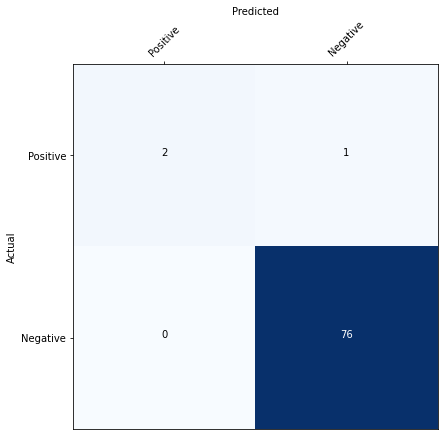

Confusion matrix for Mary Jackson:


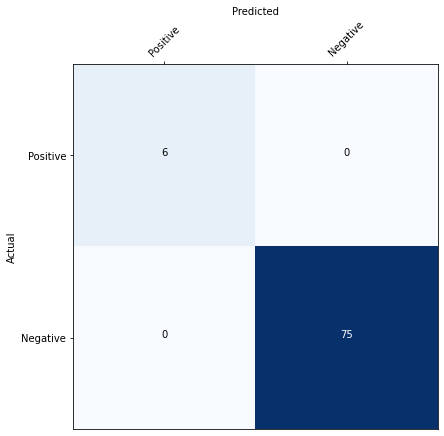

In [68]:
print('Confusion matrix for Katherine Johnson:')
plot_confusion_matrix(manual_labels = katherine_manual_labels, 
                      sorted_date_df = get_sorted_df_from_file_name_adapted(os.path.join(working_dir, 'KatherineJohnson.txt')),
                      normalize    = False,
                      title_names = ['Positive','Negative'])

print('Confusion matrix for Mary Jackson:')
plot_confusion_matrix(manual_labels = mary_manual_labels, 
                      sorted_date_df = get_sorted_df_from_file_name_adapted(os.path.join(working_dir, 'MaryJackson.txt')),
                      normalize    = False,
                      title_names = ['Positive','Negative'])

#### Task 11: Calculate the precision of your adapted date expression procedure on both KatherineJohnson.txt and MaryJackson.txt.

Write your calculations into the cell below.

Katherine Johnson's didn't change: $\frac{2}{2 + 1}$, and for Mary Jackson there are 6 dates, which all have been correctly identified by the algorithm, so $\frac{6}{6 + 0}$

#### Task 12: Compare the precisions on KatherineJohnson.txt and MaryJackson.txt. Address the following points: 
- Are there any differences? 
- If so, where does this difference come from? 
- What does this difference mean in terms of generalizability? 

There are no differences, the algorithm performs perfectly on both.

### Finding matching events
#### Task 13: Find the matching events (i.e. overlapping dates in the two biographical timelines) between the two timelines. 

You could do this in one of the following ways: 
- **Command line** We highly encourage you to use the ‘comm’ function on your ISO-8601 dates in your command line (more info and example: https://www.computerhope.com/unix/ucomm.htm. Note that this command also works on Mac OS/Windows). 
- **Python** It is also allowed to find the matching events programmatically in Python.
- **Online tool ** You can use an online tool (e.g. https://text-compare.com/).

**Important: Do not search for matching events manually!**

Please put the command, the code or the link to the website you used into the cell below or briefly describe how you found the matching events.  

Then, also paste the list of matching events (in ISO-8601 format) into that cell. 


In [57]:
mary = get_sorted_df_from_file_name(os.path.join(working_dir, 'MaryJackson.txt'))['Date']
katy = get_sorted_df_from_file_name(os.path.join(working_dir, 'KatherineJohnson.txt'))['Date']

def check_duplicates(mary, katy):
  for i in range(min(len(mary), len(katy))):
    if mary[i] in katy:
      return True
    if katy[i] in mary:
      return True
  return False
print(check_duplicates(mary, katy))


False


There are no exact dates on which something happens for both of these scientists, but there may be if entire years are included (and ranges). However, for that the dates are too inaccurate on the wikipedia pages and I understood from the assignment that specific dates are saved rather than ranges.

#### Task 14: Discussion of matching events 
1. Discuss the list of matching events that you found. 
2. When going through the texts manually, do you find matching events that you did not find programmatically/automatically? 
3. If so, what could be the reason(s) for this? Discuss your answers to these questions and any other difficulties you encountered during the extraction of matching events.

There were no matching events, so this task makes me think I missed something haha

In [58]:
print('Congratulations! You finished this assignment!')
print('We would like to thank Theo Kent for letting us use his notebook as a basis for this assignment!')

Congratulations! You finished this assignment!
We would like to thank Theo Kent for letting us use his notebook as a basis for this assignment!
